## Radio Science

This notebook demonstrates the application of radio science techniques using simulated tracking data.
The focus is on analyzing spacecraft tracking observables and evaluating how physical parameters influence measurement signals.
The notebook uses one-way range observations as a representative radio science observable.

#### - Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tudatpy.interface import spice
from tudatpy import constants
from tudatpy.dynamics import environment_setup, propagation_setup, parameters_setup
from tudatpy.estimation import observable_models_setup, observations_setup, estimation_analysis, observations
from tudatpy.estimation.observable_models_setup import links
from tudatpy.estimation.observable_models_setup.links import LinkEndType
from tudatpy.estimation.observable_models_setup.model_settings import one_way_range
from tudatpy.astro import element_conversion
from tudatpy.astro.time_representation import DateTime

#### - Kernels and Epoch

In [2]:
spice.load_standard_kernels()

simulation_start_epoch = DateTime(2016, 10, 5).to_epoch()
propagation_start_epoch = simulation_start_epoch - 3600.0
simulation_end_epoch = simulation_start_epoch + 60*24*3600
propagation_end_epoch = simulation_end_epoch + 3600.0

#### - Create Bodies, Spacecraft and Ground Station

In [3]:
bodies_to_create = ["Sun", "Jupiter", "Earth"]

global_frame_origin = "Jupiter"
global_frame_orientation = "ECLIPJ2000"

body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation
)

body_settings.add_empty_settings("Juno")
body_settings.get("Juno").constant_mass = 2000.0

bodies = environment_setup.create_system_of_bodies(body_settings)

environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "DSS-14",
    np.array([0.0, 0.0, 0.0])
)

#### - Orbital elements

In [4]:
jupiter_mu = constants.GRAVITATIONAL_CONSTANT * 1.898e27


semi_major_axis = 1.07e9
eccentricity = 0.95
inclination = np.deg2rad(90.0)
longitude_of_ascending_node = np.deg2rad(270.0) 
argument_of_periapsis = np.deg2rad(90.0)
argument_of_periapsis = 0.0
longitude_of_ascending_node = 0.0
true_anomaly = 0.0


keplerian_elements = [
    semi_major_axis,
    eccentricity,
    inclination,
    argument_of_periapsis,
    longitude_of_ascending_node,
    true_anomaly
]

In [5]:
initial_state = element_conversion.keplerian_to_cartesian(
    keplerian_elements,
    jupiter_mu
)

#### - Acceleration Models

In [6]:
spacecraft_name = "Juno"

acceleration_settings = {
    spacecraft_name: {
        "Jupiter": [propagation_setup.acceleration.spherical_harmonic_gravity(5, 0)], #Make sure point J2 exists
        "Sun": [propagation_setup.acceleration.point_mass_gravity()]
    }
}

acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    [spacecraft_name],
    ["Jupiter"]
)

In [7]:
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    propagation_start_epoch,
    10.0
)

#### - Termination and Propagation Settings

In [8]:
termination_settings = propagation_setup.propagator.time_termination(
    simulation_end_epoch
)

In [9]:
propagator_settings = propagation_setup.propagator.translational(
    ["Jupiter"],
    acceleration_models,
    [spacecraft_name],
    initial_state,
    propagation_start_epoch,
    integrator_settings,
    termination_settings
)

#### - Observation Settings

In [10]:
link_ends = dict()

link_ends[LinkEndType.transmitter] = (
    observable_models_setup.links.body_origin_link_end_id("Juno")
)

link_ends[LinkEndType.receiver] = (
    observable_models_setup.links.body_reference_point_link_end_id(
    "Earth", "DSS-14"
    )
)

link_definition = observable_models_setup.links.LinkDefinition(link_ends)

In [11]:
observable_settings = [
    one_way_range(link_definition)
]

In [12]:
observation_times = np.arange(
    simulation_start_epoch,
    simulation_end_epoch,
    60.0
)

#### - Working with Noise and Gravitational Field 

In [13]:
noise_level = 10.0 #meters

def noise_function(time):
    return np.array([np.random.normal(0, noise_level)])

simulation_settings = observations_setup.observations_simulation_settings.tabulated_simulation_settings(
    observable_type=observable_models_setup.model_settings.ObservableType.one_way_range_type,
    link_ends=link_definition,
    simulation_times=observation_times,
    noise_function=noise_function
)

In [14]:
parameter_settings = parameters_setup.initial_states(
    propagator_settings,
    bodies
)

parameter_settings.append(
    parameters_setup.spherical_harmonics_c_coefficients(
        "Jupiter", 
        2,
        0,
        2,
        0
    )
)

parameters_to_estimate = parameters_setup.create_parameter_set(
    parameter_settings,
    bodies
)

In [15]:
estimator = estimation_analysis.Estimator(
    bodies,
    parameters_to_estimate,
    observable_settings,
    propagator_settings
)

In [16]:
observation_simulators = observations_setup.observations_simulation_settings.create_observation_simulators(
    observable_settings,
    bodies
)

observations = observations_setup.observations_wrapper.simulate_observations(
    [simulation_settings],
    observation_simulators,
    bodies
)

In [17]:
estimation_input = estimation_analysis.EstimationInput(observations)

estimation_input.define_estimation_settings(
    reintegrate_variational_equations=True
)

#Add weights to observations based on 10m noise.
estimation_input.set_constant_weight_per_observable(
    {observable_models_setup.model_settings.ObservableType.one_way_range_type: 1.0 / (noise_level ** 2)}
)

In [18]:
estimation_output = estimator.perform_estimation(
    estimation_input
)

#### - Extract Residuals

In [19]:
residuals = estimation_output.final_residuals.flatten()

observation_times = observations.concatenated_times

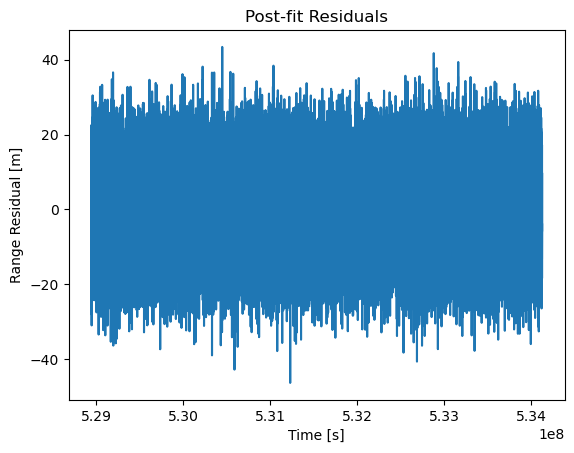

In [20]:
plt.figure()
plt.plot(observation_times, residuals)
plt.xlabel("Time [s]")
plt.ylabel("Range Residual [m]")
plt.title("Post-fit Residuals")
plt.show()

#### - Compute Residual Statistics

In [21]:
rms = np.sqrt(np.mean(residuals**2))
std = np.std(residuals)

print("Residual RMS:", rms)
print("Residual STD:", std)

Residual RMS: 10.036745020764887
Residual STD: 10.036744851895902


In [22]:
covariance_matrix = estimation_output.covariance

print(covariance_matrix)

[[ 1.57431502e-03  1.04385007e-03  2.64569556e-03 -1.85225190e-06
   2.17078249e-06 -1.05639821e-06 -1.55423809e-13]
 [ 1.04385007e-03  1.78556100e-03  1.16308824e-02 -7.67319394e-06
   3.63726974e-06 -7.09440299e-07  1.52023814e-13]
 [ 2.64569544e-03  1.16308823e-02  3.98153208e-01 -2.63171065e-04
   2.21596735e-05 -1.71841675e-06  3.94334064e-12]
 [-1.85225182e-06 -7.67319389e-06 -2.63171065e-04  1.74076022e-07
  -1.47836179e-08  1.20280665e-09 -2.55842927e-15]
 [ 2.17078249e-06  3.63726974e-06  2.21596737e-05 -1.47836180e-08
   9.38447404e-09 -1.49110693e-09  5.17680780e-16]
 [-1.05639821e-06 -7.09440301e-07 -1.71841682e-06  1.20280670e-09
  -1.49110694e-09  7.09225378e-10  9.98367560e-17]
 [-1.55423810e-13  1.52023813e-13  3.94334062e-12 -2.55842926e-15
   5.17680779e-16  9.98367566e-17  1.33100584e-22]]


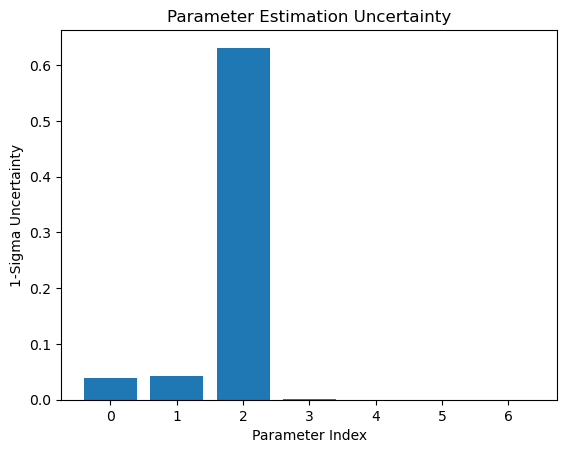

In [23]:
parameter_uncertainties = np.sqrt(np.diag(covariance_matrix))

plt.figure()
plt.bar(range(len(parameter_uncertainties)), parameter_uncertainties)
plt.xlabel("Parameter Index")
plt.ylabel("1-Sigma Uncertainty")
plt.title("Parameter Estimation Uncertainty")
plt.show()

##### Here, the noise is practically blocking the signal received by the radio telescope,
##### hence a very large uncertainty arises, mainly in the inclination axis.

##### This is because the radio only measures the distance along the line of sight between Earth and Juno,
##### which is excellent for measuring distance, but does not interpret movements perpendicular to that line well
##### (for example changes in inclination or in the plane of the orbit).

##### Now, with more observations days, the Sigma Uncertainty decrease.

## Predicte when Juno is occulted by Jupiter

In [24]:
link_end_juno = ("Juno", "") 

viability_settings = [
    observations_setup.viability.body_occultation_viability(
        link_end_juno, 
        "Jupiter"
    )
]

simulation_settings = observations_setup.observations_simulation_settings.tabulated_simulation_settings(
    observable_type=observable_models_setup.model_settings.ObservableType.one_way_range_type,
    link_ends=link_definition,
    simulation_times=observation_times,
    viability_settings=viability_settings,
    noise_function=noise_function
)

observable_settings = [
    one_way_range(link_definition)
]

observation_simulators = observations_setup.observations_simulation_settings.create_observation_simulators(
    observable_settings,
    bodies
)

In [25]:
observations_with_occultation = observations_setup.observations_wrapper.simulate_observations(
    [simulation_settings],
    observation_simulators,
    bodies
)

total_pts = len(observation_times)
valid_pts = len(observations_with_occultation.concatenated_times)

print(f"Total points planned: {total_pts}")
print(f"Valid points (outside of concealment): {valid_pts}")
print(f"Signal blocked for a {((total_pts - valid_pts)/total_pts)*100:.2f}% of the time.")

Total points planned: 86400
Valid points (outside of concealment): 86400
Signal blocked for a 0.00% of the time.
